In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torchvision.utils as vutils
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torchvision.models import alexnet, AlexNet_Weights

In [76]:
# Configuración del dispositivo (usa GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
data = os.path.join('archive', 'real_and_fake_face') #Carga de datos
initial_imagen_size = (224, 224) #Tamaño inicial del dataset
batch_size = 32

In [85]:
# Transformación de datos
data_transforms = transforms.Compose([
    transforms.Resize(initial_imagen_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0,], std=[1.0,]) #Normalizamos entre [1, -1], ya que al normalizar con [0,1] malos resultados
])

In [86]:
def separate_train_test(full_dataset, percentaje):
    return train_test_split(full_dataset, test_size=percentaje, random_state=42)

In [87]:
def separate_train_val(train_dataset, percentaje):
    return train_test_split(train_dataset, test_size=percentaje, random_state=42)

In [88]:
# Carga el conjunto de datos completo
full_dataset = datasets.ImageFolder(root=data, transform=data_transforms)

#Separa los datos en los diferentes grupos
train_dataset, test_dataset =  separate_train_test(full_dataset, 0.2)
#train_dataset, val_dataset =  separate_train_test(train_dataset, 0.2)

# Crea los dataloaders para entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [89]:
def plot_image(image, label):
    plt.imshow(image[0])
    plt.title(f'Etiqueta: {label}')
    plt.show()

In [90]:
def find_max_min(image):
    max_value = image.max().item()
    min_value = image.min().item()
    print(f'El máximo valor es: {max_value}, el mínimo es {min_value}')

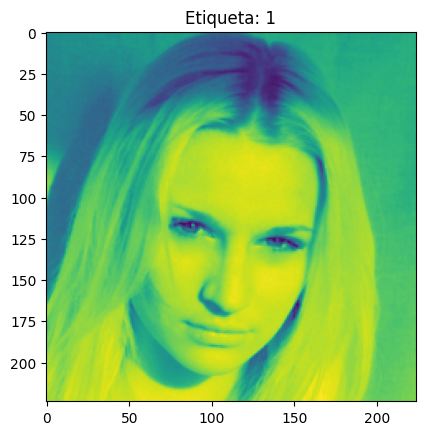

El máximo valor es: 0.9176470637321472, el mínimo es 0.003921568859368563


In [91]:
img, label = test_dataset[0]
plot_image(img, label)
find_max_min(img)

In [92]:
def count_labels(dataloader):
    size = len(dataloader.dataset)
    label_0 = 0
    label_1 = 0

    for _, labels in dataloader:
        label_0 += (labels == 0).sum().item()
        label_1 += (labels == 1).sum().item()

    results = {"size": size, "label_0": label_0, "label_1": label_1}
    return results

In [93]:
results_train = count_labels(train_loader)
#results_val = count_labels(val_loader)
results_test = count_labels(test_loader)
print(f'Para los datos de train tenemos {results_train}')
#print(f'Para los datos de train tenemos {results_val}')
print(f'Para los datos de test tenemos {results_test}')

Para los datos de train tenemos {'size': 1632, 'label_0': 768, 'label_1': 864}
Para los datos de test tenemos {'size': 409, 'label_0': 192, 'label_1': 217}


In [98]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Nueva capa convolucional
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(50176, 128),  # Ajuste el tamaño de esta capa
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [99]:
model = SimpleCNN(2)
model = model.to(device)
# Definiendo la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adadelta(model.parameters(), lr=1) #cambiamos adadelta por adam

In [100]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device  # Agrega el atributo 'device' a la clase
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []

    def calculate_accuracy(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)  # Mover los datos a la GPU
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        return accuracy

    def calculate_loss(self, loader):
        self.model.eval()
        loss = 0.0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)  # Mover los datos a la GPU
                outputs = self.model(images)
                loss += self.criterion(outputs, labels).item()
        loss /= len(loader)
        return loss

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            self.model.train()
            train_accuracy = self.calculate_accuracy(self.train_loader)
            train_loss = self.calculate_loss(self.train_loader)

            correct = 0
            total = 0
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)  # Mover los datos a la GPU
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_accuracy = 100 * correct / total
            train_loss = loss.item()

            test_loss = self.calculate_loss(self.test_loader)
            test_accuracy = self.calculate_accuracy(self.test_loader)

            self.train_losses.append(train_loss)
            self.test_losses.append(test_loss)
            self.train_accuracies.append(train_accuracy)
            self.test_accuracies.append(test_accuracy)

            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

In [101]:
trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)
trainer.train(num_epochs=10)

Epoch 1/10: Train Loss: 0.6913, Train Accuracy: 53.00%, Test Loss: 0.6913, Test Accuracy: 53.06%
Epoch 2/10: Train Loss: 0.7084, Train Accuracy: 52.94%, Test Loss: 0.6921, Test Accuracy: 53.06%
Epoch 3/10: Train Loss: 0.6951, Train Accuracy: 54.17%, Test Loss: 0.6983, Test Accuracy: 47.43%
Epoch 4/10: Train Loss: 0.6875, Train Accuracy: 56.68%, Test Loss: 0.6917, Test Accuracy: 52.32%
Epoch 5/10: Train Loss: 0.6822, Train Accuracy: 56.37%, Test Loss: 0.6979, Test Accuracy: 51.34%
Epoch 6/10: Train Loss: 0.6323, Train Accuracy: 58.95%, Test Loss: 0.6873, Test Accuracy: 56.48%
Epoch 7/10: Train Loss: 0.6296, Train Accuracy: 60.48%, Test Loss: 0.6881, Test Accuracy: 56.23%
Epoch 8/10: Train Loss: 0.6257, Train Accuracy: 61.89%, Test Loss: 0.6812, Test Accuracy: 58.68%
Epoch 9/10: Train Loss: 0.6244, Train Accuracy: 62.38%, Test Loss: 0.6769, Test Accuracy: 59.66%
Epoch 10/10: Train Loss: 0.5603, Train Accuracy: 64.64%, Test Loss: 0.6763, Test Accuracy: 57.95%


In [105]:
class TumorClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifierResNet, self).__init__()

        # Cargar el modelo ResNet-18 preentrenado
        weights = AlexNet_Weights.DEFAULT
        resnet = alexnet(weights=weights)

        # Congelar todas las capas convolucionales
        for param in resnet.parameters():
            param.requires_grad = True

        # Descongelar las últimas capas convolucionales
        #for name, param in resnet.layer4.named_parameters():
        #param.requires_grad = True

        # Modificar la capa de clasificación (fully connected)
        num_features = resnet.classifier[6].in_features
        resnet.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(256, num_classes)
        )

        self.model = resnet

    def forward(self, x):
        return self.model(x)

In [106]:
model = TumorClassifierResNet(num_classes=2).to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\jorge/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:21<00:00, 11.3MB/s] 


In [108]:
# Entrenamiento
num_epochs = 10
history = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 0:
            print(f'Epoch {epoch+1}, Batch {i}, Loss: {running_loss/10:.4f}')
            history.append(running_loss/10)
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 10, Loss: 0.6979
Epoch 1, Batch 20, Loss: 0.7009
Epoch 1, Batch 30, Loss: 0.7053
Epoch 1, Batch 40, Loss: 0.6986
Epoch 1, Batch 50, Loss: 0.6981
Epoch 2, Batch 10, Loss: 0.6910
Epoch 2, Batch 20, Loss: 0.7124
Epoch 2, Batch 30, Loss: 0.6949
Epoch 2, Batch 40, Loss: 0.6992
Epoch 2, Batch 50, Loss: 0.7057
Epoch 3, Batch 10, Loss: 0.7001
Epoch 3, Batch 20, Loss: 0.7086
Epoch 3, Batch 30, Loss: 0.7005
Epoch 3, Batch 40, Loss: 0.7009
Epoch 3, Batch 50, Loss: 0.6912
Epoch 4, Batch 10, Loss: 0.7019
Epoch 4, Batch 20, Loss: 0.7006
Epoch 4, Batch 30, Loss: 0.6936
Epoch 4, Batch 40, Loss: 0.7028
Epoch 4, Batch 50, Loss: 0.7015
Epoch 5, Batch 10, Loss: 0.7008
Epoch 5, Batch 20, Loss: 0.7097
Epoch 5, Batch 30, Loss: 0.6976
Epoch 5, Batch 40, Loss: 0.7019
Epoch 5, Batch 50, Loss: 0.6916
Epoch 6, Batch 10, Loss: 0.6973
Epoch 6, Batch 20, Loss: 0.6994
Epoch 6, Batch 30, Loss: 0.6963
Epoch 6, Batch 40, Loss: 0.7061
Epoch 6, Batch 50, Loss: 0.7000
Epoch 7, Batch 10, Loss: 0.6986
Epoch 7,